In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'ENPM809K Assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/ENPM809K Assignments/assignment1/cs231n/datasets
/content/drive/My Drive/ENPM809K Assignments/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

#using the same learning rates and regularization strengths as last time
learning_rates = [1e-7, 1e-5, 1e-3, 1e-1]
regularization_strengths = [1e-7, 1e-5, 1e-3, 1e-1]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

svm = LinearSVM() #Creating an svm instance to access the classifier

#First, we iterate through each learning rate
#Second, for each learning rate, we iterate through each regularization to find the fit
for learn_rate in learning_rates:
  for reg_strength in regularization_strengths:
    
    #Third, we train our classifier, but instead of training it on all image pixels, we'll do it on image features
    loss_function = svm.train(X_train_feats, y_train, learning_rate = learn_rate, reg = reg_strength, num_iters=1000)
    
    #Fourth, we predict the classes on training data's features and estimate the accuracy
    y_pred_train = svm.predict(X_train_feats)
    training_accuracy = np.mean(y_pred_train == y_train)

    #Fifth, we predict the classes on the validation set's features and estimate its accuracy
    y_pred_validation = svm.predict(X_val_feats)
    validation_accuracy = np.mean(y_pred_validation == y_val)

    #Next, store these accuracies as dictionaries in the result dict.
    results[(learn_rate, reg_strength)] = (training_accuracy, validation_accuracy)

    #Lastly, we check if the validation accuracy is better than the best validation accuracy and then update it accordingly
    if validation_accuracy > best_val:
      best_val = validation_accuracy
      best_svm = svm #The current SVM will be the best SVM for this iteration

"""Note here, that by increasing/decreasing the number of iteration in our training of the SVM
we can have an direct effect on our validation accuracy"""

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-07 reg 1.000000e-07 train accuracy: 0.130755 val accuracy: 0.149000
lr 1.000000e-07 reg 1.000000e-05 train accuracy: 0.143286 val accuracy: 0.152000
lr 1.000000e-07 reg 1.000000e-03 train accuracy: 0.155082 val accuracy: 0.161000
lr 1.000000e-07 reg 1.000000e-01 train accuracy: 0.166673 val accuracy: 0.167000
lr 1.000000e-05 reg 1.000000e-07 train accuracy: 0.409959 val accuracy: 0.413000
lr 1.000000e-05 reg 1.000000e-05 train accuracy: 0.415347 val accuracy: 0.420000
lr 1.000000e-05 reg 1.000000e-03 train accuracy: 0.416531 val accuracy: 0.424000
lr 1.000000e-05 reg 1.000000e-01 train accuracy: 0.417878 val accuracy: 0.429000
lr 1.000000e-03 reg 1.000000e-07 train accuracy: 0.496612 val accuracy: 0.484000
lr 1.000000e-03 reg 1.000000e-05 train accuracy: 0.505143 val accuracy: 0.494000
lr 1.000000e-03 reg 1.000000e-03 train accuracy: 0.508816 val accuracy: 0.489000
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 0.510245 val accuracy: 0.489000
lr 1.000000e-01 reg 1.000000

In [ ]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.468


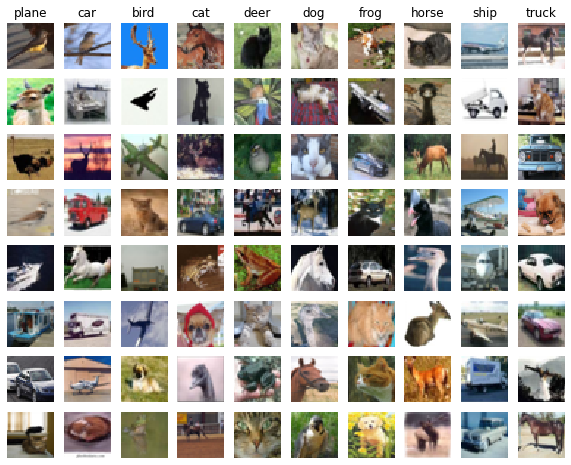

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ There is definitely a scope for misclassification. Coming to describing them, if you see them on a higher level, it seems like it doesn't make any sense. But upon a closer look, since we are concatenting two different kinds of features to arrive at a feature vector, namely the Histogram of Gradients (HoG) and Colour Histogram. With HoG, it classifies images with the similar features and their orientations. But since we are not actually measuring pixel to pixel, it doesn't really take into account where that oriented gradient is, it just sees that two images have an equal distribution of the oriented gradients in its histogram, so the classifier assumes that both images mus be from the same class. Similarly, with the histogram of colours, if between two images the colour distribution histogram is more of less the same, the images are classified as a same class. \

In my classifier, it makes sense at some places and not much sense with others. It has clssified a lot of trucks as cars. Since both of them, more or less, would have similar looking features (body, wheels, tyres etc.), their HoG might have been such that the trucks would've been classified as cars. 
Even in the case of the planes class, it is simply classing wrong images which might pass of as a plane (i.e too much blue in the background) as the plane class (maybe the result of the features produced from the colour Histogram). \

Now in some cases, it doesn't make sense as to why a certain image was classified as such, for eg. a cat was classified as a plane. Upon studying the image, one can't really point as to which features of the cat must've contributed to the model for it to be clasified as a plane. In such cases, the prediction is just bad and one can't take away a lot from it. \


Note: The example above answer may not exactly match the image result produced, because with each compilation, a different set of images are produced. I saw this change after having written the original answer.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 600 #tweaked this to get required results
num_classes = 10


best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results = {}
best_val = -1

#same sets for learning rates and regularization strengths as last time
learning_rates = [1e-7, 1e-5, 1e-3, 1e-1]
regularization_strengths = [1e-7, 1e-5, 1e-3, 1e-1]

#saving the input features as train, validation, and test
#Saving their respective labels in the y variables
data = {
      'X_train': X_train_feats, # training data
      'y_train': y_train, # training labels
      'X_val': X_val_feats, # validation data
      'y_val': y_val, # validation labels
      'X_test': X_test_feats, #test data
      'y_test': y_test, #test labels
}

count_learn = 0 #just used to understand the iterations in the output
#First, we iterate through each learning rate
#Second, for each learning rate, we iterate through each regularization to find the fit
for learn_rate in learning_rates:
  count_reg = 0
  for reg_strength in regularization_strengths:
    #Third, we create our model
    print("Iteration: lr_iteration = %d reg_iteration = %d" %(count_learn, count_reg))
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg= reg_strength)
    #Fourth, we make a solver instance for the model
    solver = Solver(net, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learn_rate,
                    },
                    lr_decay=0.95,
                    num_epochs=4, batch_size=100,
                    print_every=100)
    #Fifth, we train the model
    solver.train()
    #Sixth, store the best validation accuracy as dictionaries in the result dict for the current values of lr and reg.
    results[(learn_rate, reg_strength)] = solver.best_val_acc

    #Lastly, we check if the validation accuracy is better than the best validation accuracy and then update it accordingly
    if  results[(learn_rate, reg_strength)] > best_val:
      best_val = results[(learn_rate, reg_strength)]
      best_net = net #The current model will be the best model for this iteration
    count_reg += 1 #increasing out counter just understand the iterations
  count_learn += 1
    

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (
                lr, reg, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Iteration: lr_iteration = 0 reg_iteration = 0
(Iteration 1 / 1960) loss: 2.302644
(Epoch 0 / 4) train acc: 0.101000; val_acc: 0.096000
(Iteration 101 / 1960) loss: 2.302611
(Iteration 201 / 1960) loss: 2.302603
(Iteration 301 / 1960) loss: 2.302601
(Iteration 401 / 1960) loss: 2.302618
(Epoch 1 / 4) train acc: 0.098000; val_acc: 0.096000
(Iteration 501 / 1960) loss: 2.302597
(Iteration 601 / 1960) loss: 2.302569
(Iteration 701 / 1960) loss: 2.302556
(Iteration 801 / 1960) loss: 2.302566
(Iteration 901 / 1960) loss: 2.302607
(Epoch 2 / 4) train acc: 0.105000; val_acc: 0.096000
(Iteration 1001 / 1960) loss: 2.302594
(Iteration 1101 / 1960) loss: 2.302599
(Iteration 1201 / 1960) loss: 2.302587
(Iteration 1301 / 1960) loss: 2.302594
(Iteration 1401 / 1960) loss: 2.302589
(Epoch 3 / 4) train acc: 0.099000; val_acc: 0.096000
(Iteration 1501 / 1960) loss: 2.302579
(Iteration 1601 / 1960) loss: 2.302596
(Iteration 1701 / 1960) loss: 2.302584
(Iteration 1801 / 1960) loss: 2.302646
(Iteration 19

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.54
